<a href="https://colab.research.google.com/github/TirendazAcademy/Hugging-Face-Tutorials/blob/main/Sentiment_Analysis_with_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 8.7 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
emotions = load_dataset("emotion")
emotions

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [ ]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
def label_converter(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_converter)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


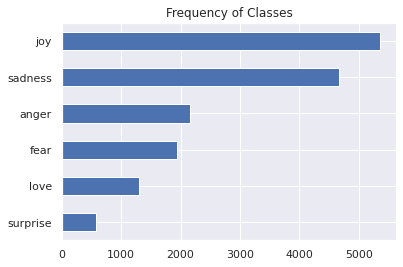

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [ ]:
emotions.reset_format()

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.1 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
print(tokenize_function(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
tokenized_datasets = emotions.map(tokenize_function, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
print(tokenized_datasets["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(output_dir="finetuning-emotion-model",
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=64,
                                  per_device_eval_batch_size=64,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  push_to_hub=True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_datasets["train"],
                  eval_dataset=tokenized_datasets["validation"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/Tirendaz/finetuning-emotion-model into local empty directory.
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16000
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 500
  Number of trainable parameters = 66958086
You're using a DistilBertTokenizerFa

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.319096,0.907000,0.905225
2,0.550300,0.224044,0.922500,0.922613


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to finetuning-emotion-model/checkpoint-500
Configuration saved in finetuning-emotion-model/checkpoint-500/config.json
Model weights saved in finetuning-emotion-model/checkpoint-500/pytorch_model.bin
tokenizer config file saved in finetuning-emotion-model/checkpoint-500/tokenizer_config.json
Special tokens file saved in finetuning-emotion-model/checkpoint-500/special_tokens_map.json
tokenizer config file saved in finetuning-emotion-model/tokenizer_config.json
Special tokens file saved in finetuning-emotion-model/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBert

In [ ]:
preds_output = trainer.predict(tokenized_datasets["validation"])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 64


In [ ]:
preds_output.metrics

{'test_loss': 0.22404372692108154,
 'test_accuracy': 0.9225,
 'test_f1': 0.9226133034678037,
 'test_runtime': 4.1636,
 'test_samples_per_second': 480.358,
 'test_steps_per_second': 7.686}

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

Saving model checkpoint to finetuning-emotion-model
Configuration saved in finetuning-emotion-model/config.json
Model weights saved in finetuning-emotion-model/pytorch_model.bin
tokenizer config file saved in finetuning-emotion-model/tokenizer_config.json
Special tokens file saved in finetuning-emotion-model/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Feb12_08-52-20_6cd86fd09f7c/events.out.tfevents.1676191949.6cd86fd09f7c.1228.0: 100%|########…

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/Tirendaz/finetuning-emotion-model
   be4b75e..b90241a  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Tirendaz/finetuning-emotion-model
   be4b75e..b90241a  main -> main

To https://huggingface.co/Tirendaz/finetuning-emotion-model
   b90241a..fcb719e  main -> main

   b90241a..fcb719e  main -> main



'https://huggingface.co/Tirendaz/finetuning-emotion-model/commit/b90241a01bcbae21bccff423ec2c5b138918edaa'

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model="Tirendaz/finetuning-emotion-model")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Tirendaz--finetuning-emotion-model/snapshots/fcb719e87e9a417e2b91e68ea4cba04c9c5b62c9/config.json
Model config DistilBertConfig {
  "_name_or_path": "Tirendaz/finetuning-emotion-model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
 

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--Tirendaz--finetuning-emotion-model/snapshots/fcb719e87e9a417e2b91e68ea4cba04c9c5b62c9/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at Tirendaz/finetuning-emotion-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--Tirendaz--finetuning-emotion-model/snapshots/fcb719e87e9a417e2b91e68ea4cba04c9c5b62c9/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--Tirendaz--finetuning-emotion-model/snapshots/fcb719e87e9a417e2b91e68ea4cba04c9c5b62c9/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--Tirendaz--finetuning-emotion-model/snapshots/fcb719e87e9a417e2b91e68ea4cba04c9c5b62c9/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--Tirendaz--finetuning-emotion-model/snapshots/fcb719e87e9a417e2b91e68ea4cba04c9c5b62c9/tokenizer_config.json


In [36]:
preds = classifier(["I love this move and it is really good."], return_all_scores=True)

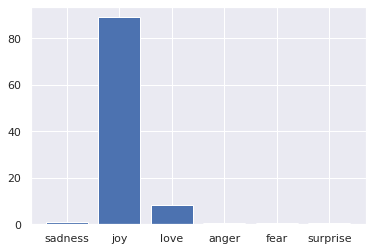

In [37]:
labels = emotions["train"].features["label"].names
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.show()